<a href="https://colab.research.google.com/github/Himanshu-Goyal9215/Toxicity_Analysis/blob/main/Toxicity_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow  pandas matplotlib

In [4]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf


In [8]:
df=pd.read_csv(os.path.join('/content/drive/MyDrive/Colab_Notebooks/Comment_Toxicity_Classification/train.csv'))

In [9]:
df.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


In [11]:
from tensorflow.keras.layers import TextVectorization

In [13]:
X=df['comment_text']
y=df[df.columns[2:]].values



In [14]:
tokenize=TextVectorization(max_tokens=200000,output_sequence_length=1800,output_mode='int')

In [15]:
tokenize.adapt(X.values)

In [ ]:
tokenize.get_vocabulary()


In [20]:
vectorized=tokenize(X.values)

In [21]:
vectorized

<tf.Tensor: shape=(159571, 1800), dtype=int64, numpy=
array([[  645,    76,     2, ...,     0,     0,     0],
       [    1,    54,  2489, ...,     0,     0,     0],
       [  425,   441,    70, ...,     0,     0,     0],
       ...,
       [32445,  7392,   383, ...,     0,     0,     0],
       [    5,    12,   534, ...,     0,     0,     0],
       [    5,     8,   130, ...,     0,     0,     0]])>

In [22]:
dataset=tf.data.Dataset.from_tensor_slices((vectorized,y))
dataset=dataset.cache()
dataset=dataset.shuffle(100000)
dataset=dataset.batch(16)
dataset=dataset.prefetch(8)

In [23]:
train=dataset.take(int(len(dataset)*.7))
val=dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test=dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

In [48]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding, Input

In [49]:
MAX_FEATURES = 200000
input_length=1800

In [50]:
Model= Sequential()

Model.add(Input(shape=(input_length,)))

Model.add(Embedding(MAX_FEATURES+1,64))
Model.add(Bidirectional(LSTM(64,activation='tanh',return_sequences=True)))
Model.add(Bidirectional(LSTM(64,activation='tanh')))

Model.add(Dense(128,activation='relu'))
Model.add(Dense(256,activation='relu'))
Model.add(Dense(128,activation='relu'))
Model.add(Dense(6,activation='sigmoid'))

In [51]:
Model.compile(loss='BinaryCrossentropy',optimizer='Adam')

In [52]:
Model.summary()


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_10 (Embedding)             │ (None, 1800, 64)            │      12,800,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_17 (Bidirectional)     │ (None, 1800, 128)           │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_18 (Bidirectional)     │ (None, 128)                 │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,048,134 (49.77 MB)

 Trainable params: 13,048,134 (49.77 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history=Model.fit(train,epochs=2,validation_data=val)

In [56]:
history.history

{'loss': [0.05871160700917244, 0.045679252594709396],
 'val_loss': [0.04548565298318863, 0.040741678327322006]}

In [58]:
from matplotlib import pyplot as plt

<Figure size 800x500 with 0 Axes>

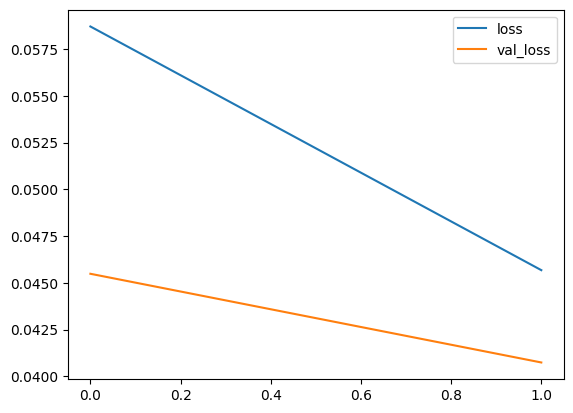

In [59]:
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

In [60]:
input=tokenize(['I will hit you!'])

In [61]:
res=Model.predict(input)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step


In [62]:
(res>0.5).astype(int)

array([[0, 0, 0, 0, 0, 0]])

In [63]:
batch_X,batch_y=test.as_numpy_iterator().next()

In [65]:
(Model.predict(batch_X)>.5).astype(int)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 950ms/step


array([[1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [66]:
from tensorflow.keras.metrics import Precision,Recall,CategoricalAccuracy
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [ ]:
for batch in test.as_numpy_iterator():
      X_true,y_true = batch
      yhat=Model.predict(X_true)
      y_true=y_true.flatten()
      yhat=yhat.flatten()

      pre.update_state(y_true,yhat)
      re.update_state(y_true,yhat)
      acc.update_state(y_true,yhat)


In [ ]:
!pip install gradio jinja2

In [77]:
import gradio as gr

In [ ]:
Model.save('/content/drive/MyDrive/Colab_Notebooks/Comment_Toxicity_Classification/toxicity.h5')


In [ ]:
model = tf.keras.models.load_model('toxicity.h5')

In [81]:
input_str = tokenize('hey i freaken hate you!')

In [84]:
def score_comment(comment):
    vectorized_comment = tokenize([comment])
    results = model.predict(vectorized_comment)

    text = ''
    for idx, col in enumerate(df.columns[2:]):
        text += '{}: {}\n'.format(col, results[0][idx]>0.5)

    return text

In [86]:
interface = gr.Interface(
    fn=score_comment,
    inputs=gr.Textbox(lines=2, placeholder='Comment to score'),
    outputs='text'
)


In [87]:
interface.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://6257568b670d300b7c.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
